In [1]:
using ForwardDiff, LinearAlgebra, Random, Statistics, NNlib, LinearAlgebra
const FD = ForwardDiff;

In [246]:
nnLayer(x,W,b,σ) = σ.(reshape(W,(size(b,1),:))*x .+ b)

function getRandomParams(layerStructure)
    nParams = sum(X[1][1]*X[1][2]+X[1][2] for X in layerStructure);
    return randn(Float32,nParams)
end

function neuralNet(x,layerStructure,params)
    X = x;
    n = 1;
    for (layer, σ) in layerStructure
        X = nnLayer(X,params[n:(n-1+layer[1]*layer[2])],params[(n+layer[1]*layer[2]) : (n-1+layer[1]*layer[2]+layer[2])],σ)
        n += layer[1]*layer[2]+layer[2];
    end
    return X
end

layerStructure = [
    (2 => 20,NNlib.σ),
    (20 => 20,NNlib.σ),
    # (40 => 40,NNlib.tanh_fast),
    # (40 => 40,NNlib.tanh_fast),
    # (40 => 40,tanh),
    # (40 => 40,tanh),
    (20 => 1,identity) # Re, Im
];

ϕmodel(xt,params) = neuralNet(xt,layerStructure,params);
initParams = getRandomParams(layerStructure);

In [115]:
using BenchmarkTools

In [116]:
using Zygote

In [3]:
xmin = 0; xmax = 1; Tmax = 1;
V(x) = 0;
nxCollocationPts = 20;
nyCollocationPts = 20;
nCollocationPts = nxCollocationPts * nyCollocationPts;
# nCollocationPts = 400;
n∂t0pts = 150;
n∂xpts = 150;
collocationPts = hcat(reshape(collect.(Iterators.product(range(0,xmax,nxCollocationPts), range(0,xmax,nyCollocationPts))),:)...) |> Matrix{Float32};
# collocationPts = (collect∘transpose∘hcat)(rand(nCollocationPts),Tmax*rand(nCollocationPts)) |> Matrix{Float32};
∂t0pts = hcat(reshape(collect.(Iterators.product(range(0,xmax,n∂t0pts), 0:0)),:)...) |> Matrix{Float32};
# ∂t0pts = (collect∘transpose∘hcat)(xmax*rand(n∂t0pts),zeros(n∂t0pts)) |> Matrix{Float32};
∂xpts = hcat(reshape(collect.(Iterators.product(range(0,xmax,n∂xpts), 0:1)),:)...) |> Matrix{Float32}
# ∂xpts = hcat((collect∘transpose∘hcat)(zeros(n∂xpts),Tmax*rand(n∂xpts)),(collect∘transpose∘hcat)(xmax*ones(n∂xpts),Tmax*rand(n∂xpts)))  |> Matrix{Float32};
σinit = 0.1;
ϕt0 = (xt -> exp(-(xt[1] - xmax/2)^2/(2*σinit^2))).(eachcol(∂t0pts)) |> Vector{Float32};
dϕt0 = (xt -> 0).(eachcol(∂t0pts)) |> Vector{Float32};
ϕx0 = zeros(2n∂xpts) |> Vector{Float32};

In [28]:
# hcat(reshape(collect.(Iterators.product(range(0,xmax,n∂t0pts), 0:0)),:)...) |> Matrix{Float32}
hcat(reshape(collect.(Iterators.product(range(0,xmax,n∂xpts), 0:1)),:)...) |> Matrix{Float32}

2×300 Matrix{Float32}:
 0.0  0.00671141  0.0134228  0.0201342  …  0.979866  0.986577  0.993289  1.0
 0.0  0.0         0.0        0.0           1.0       1.0       1.0       1.0

In [24]:
# [x for x in range(0,xmax,nCollocationPts)]
let nxCollocationPts = 20, nyCollocationPts = 20
    hcat(reshape(collect.(Iterators.product(range(0,xmax,nxCollocationPts), range(0,xmax,nyCollocationPts))),:)...)
end

2×400 Matrix{Float64}:
 0.0  0.0526316  0.105263  0.157895  …  0.842105  0.894737  0.947368  1.0
 0.0  0.0        0.0       0.0          1.0       1.0       1.0       1.0

In [294]:
function waveLoss(model,params)
    # Dfs = [FD.gradient(Y->model(Y,params)[1],X) for X in eachcol(collocationPts)];
    DDfs = [FD.jacobian(X -> FD.gradient(Y->model(Y,params)[1],X),Z) for Z in eachcol(collocationPts)];
    return (
        mean(abs2(DDfs[i][2,2] - DDfs[i][1,1]) for i in 1:nCollocationPts) 
        + 15mean(abs2.(ϕmodel(∂xpts,params)[:] - ϕx0)) 
        + 15mean(abs2.(ϕmodel(∂t0pts,params)[:] - ϕt0))
        + mean(abs2(FD.gradient(Y->model(Y,params)[1],∂t0pts[:,i])[2]-dϕt0[i]) for i in eachindex(dϕt0))
        )
    # mean(abs2(DDfs[i][2,2] - DDfs[i][1,1]) for i in 1:nCollocationPts) + 15mean(abs2.(ϕmodel(∂xpts,params)[:] - ϕx0)) + 15mean(abs2.(ϕmodel(∂t0pts,params)[:] - ϕt0))
end

function diffusionLoss(model,params)
    Dfs = [FD.gradient(Y->model(Y,params)[1],X) for X in eachcol(collocationPts)];
    DDfs = [FD.jacobian(X -> FD.gradient(Y->model(Y,params)[1],X),Z) for Z in eachcol(collocationPts)];
    mean(abs2(Dfs[i][2] - DDfs[i][1,1]) for i in 1:nCollocationPts) + 15mean(abs2.(ϕmodel(∂xpts,params)[:] - ϕx0)) + 15mean(abs2.(ϕmodel(∂t0pts,params)[:] - ϕt0))
    # mean(abs2(DDfs[i][2,2] - DDfs[i][1,1]) for i in 1:nCollocationPts) + 15mean(abs2.(ϕmodel(∂xpts,params)[:] - ϕx0)) + 15mean(abs2.(ϕmodel(∂t0pts,params)[:] - ϕt0))
end

diffusionLoss (generic function with 1 method)

In [295]:
# FD.gradient(p->diffusionLoss(ϕmodel,p),initParams)
FD.gradient(p->waveLoss(ϕmodel,p),initParams)
# atest(ϕmodel,initParams)

501-element Vector{Float32}:
    7.1012278
    2.3854504
   -8.601823
   -1.1352247
   -9.877684
   -1.6227093
   -3.8049982
    2.9493625
   15.2954
    2.8097103
   -1.289701
   10.34958
  -14.131983
    ⋮
  -12.202192
  -29.266628
  -20.690016
 -195.74258
 -183.45213
 -110.086716
 -192.47092
  -87.67208
 -193.91455
  -26.686865
 -192.59343
 -199.83359

In [296]:
using Optimization, OptimizationOptimJL, OptimizationFlux, ForwardDiff

In [312]:
# optf = OptimizationFunction((p,_)->diffusionLoss(ϕmodel,p), Optimization.AutoForwardDiff())
optf = OptimizationFunction((p,_)->waveLoss(ϕmodel,p), Optimization.AutoForwardDiff())
# prob = OptimizationProblem(optf, initParams)
prob = OptimizationProblem(optf, sol.u)
# sol = solve(prob,OptimizationFlux.ADAM(),maxiters=100,maxtime=600)
# function callb(p,lossval)
#     # Do some analysis

#     # When lossval < 0.01, stop the optimization
#     # lossval < 0.01
#     println(lossval);
#     false
# end
sol = solve(prob,OptimizationOptimJL.BFGS(),maxiters=10,callback=((_,lossval) -> (println(lossval); false)))

0.37081015
0.37068093
0.370667
0.3706448
0.37057254
0.37051287
0.37021318
0.370028
0.36987364
0.36977503
0.3694271


u: 501-element Vector{Float32}:
 -1.67607
  0.7127693
 -0.22869204
 11.111647
  2.6691532
 -0.89122695
  1.1766357
 -6.164623
 -1.651115
 -0.5052701
  4.39162
  1.6190147
  1.2455176
  ⋮
 -1.4387865
 -2.2428527
 -0.3275774
  0.27847
  1.2788787
  3.8498845
  1.9564526
 -6.7713017
  4.6728325
  1.2263085
 -1.1824727
  0.03960769

In [313]:
# diffusionLoss(ϕmodel,sol.u)
waveLoss(ϕmodel,so`l.u)

0.3694271f0

In [299]:
using Plots, PlotThemes; theme(:dao)

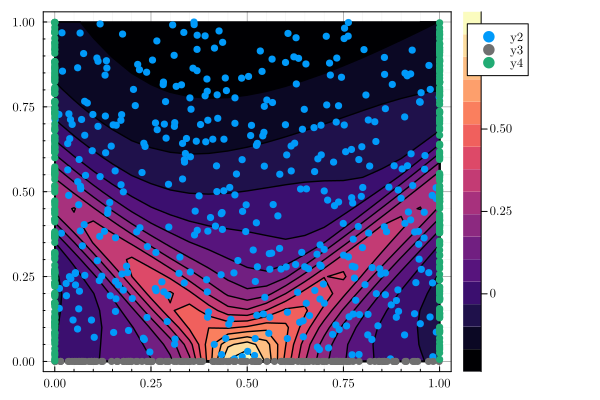

In [303]:
let xs = 0:0.05:1, ts = 0:0.05:Tmax
    # vals = reshape([ϕmodel([x, t], initParams)[1] for x in xs for t in ts],(length(xs),length(ts)));
    vals = reshape([ϕmodel([x, t], sol.u)[1] for x in xs for t in ts],(length(xs),length(ts)));
    plot(ts,xs,vals,linetype=:contourf)
    scatter!(eachrow(collocationPts)...)
    scatter!(eachrow(∂t0pts)...)
    scatter!(eachrow(∂xpts)...)
end

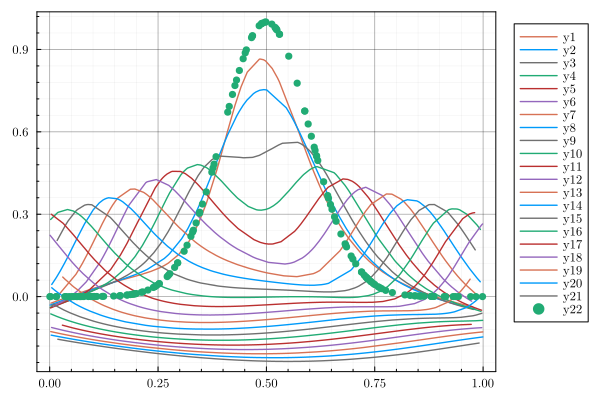

In [304]:
# loss(ϕmodel, sol.u)
# plot(meow[1,:],vec(ϕmodel(meow, initParams)))
plot()
for t in 0:0.05:Tmax
    meow = (collect∘transpose∘hcat)(xmax*sort(rand(100)),t*ones(100));
    # plot!(meow[1,:],vec(ϕmodel(meow, initParams)))
    plot!(meow[1,:],vec(ϕmodel(meow, sol.u)))
end
# for t in 0:0.1:Tmax
#     meow = (collect∘transpose∘hcat)(xmax*sort(rand(100)),t*ones(100));
#     plot!(meow[1,:],vec(ϕmodel(meow, sol.u)))
# end
scatter!(∂t0pts[1,:],ϕt0)